In [1]:
import re
import os
import cv2
import easyocr
import random
import numpy as np
from matplotlib import pyplot as plt
from ppocr_det import PPOCRDet
from typing import Optional, List

## Распознавание текста на изображениях

Код ниже подготавливает три компонента:

- **EasyOCR** — распознаёт текст (русский язык, используется GPU).
- **PPOCR (PaddleOCR)** — находит текстовые области на изображении.
- **EDSR (суперрезолюция)** — улучшает качество изображения перед распознаванием.

Используется:
- ONNX-модель детектора текста (`text_detection_cn_ppocrv3_2023may.onnx`)
- Модель повышения чёткости (`EDSR_x4.pb`)

In [2]:
reader = easyocr.Reader(['ru'], gpu=True)

ppocr_model = PPOCRDet(
    modelPath='./text_detection_cn_ppocrv3_2023may.onnx',
    inputSize=[736, 736],
    binaryThreshold=0.3,
    polygonThreshold=0.5,
    maxCandidates=200,
    unclipRatio=2.0,
    backendId=cv2.dnn.DNN_BACKEND_OPENCV,
    targetId=cv2.dnn.DNN_TARGET_CPU)

sr = cv2.dnn_superres.DnnSuperResImpl_create()
sr.readModel("EDSR_x4.pb")
sr.setModel("edsr", 4)     

In [ ]:
def extract_frames_with_plates(video_path, max_frames=10):
    cap = cv2.VideoCapture(video_path)
    selected_frames = []
    frame_count = 0

    while cap.isOpened() and len(selected_frames) < max_frames:
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_count += 60

        # Пример предобработки кадра: перевод в серый и порог
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (5,5), 0)
        _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Найдем контуры
        contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        # Пример простого фильтра: ищем прямоугольники, похожие по размеру и пропорциям на номер
        plate_like_contours = []
        0
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            aspect_ratio = w / float(h)
            area = w * h
            # Условия можно настроить под номера (примерные):
            if 1000 < area < 15000 and 2 < aspect_ratio < 6:
                plate_like_contours.append((x, y, w, h))

        # Если нашли хотя бы один "подозрительный" контур - считаем, что номер есть
        if plate_like_contours:
            selected_frames.append(frame)

        # Опционально можно пропускать кадры для ускорения, например считывать 1 из 3

    cap.release()
    return selected_frames

video_file = "D:\\TGU_projects\\CV_final_project\\dataset\\cam1.mp4"
plates_frames = extract_frames_with_plates(video_file, max_frames=10)

for i, frame in enumerate(plates_frames):
    cv2.imwrite(f"frame_with_plate_{i+1}.jpg", frame)


## Загрузка и отображение изображений

Этот код выполняет две основные задачи:

1. **load_images(folder_name)** — загружает все `.jpg` и `.jpeg` изображения из указанной папки:
   - Преобразует изображения в формат RGB.
   - Выводит сообщение о каждом успешно загруженном или пропущенном файле.

2. **display_images(images, titles)** — отображает загруженные изображения в виде сетки:
   - Подписывает каждое изображение.
   - Удаляет оси и корректно размещает элементы на графике.

Загрузка всех изображений из папки `dataset` и их визуализация.


1. ЗАГРУЗКА ВСЕХ ИЗОБРАЖЕНИЙ ИЗ ПАПКИ DATASET
Загружено: car1.jpg
Загружено: car2.jpg
Загружено: car3.jpg


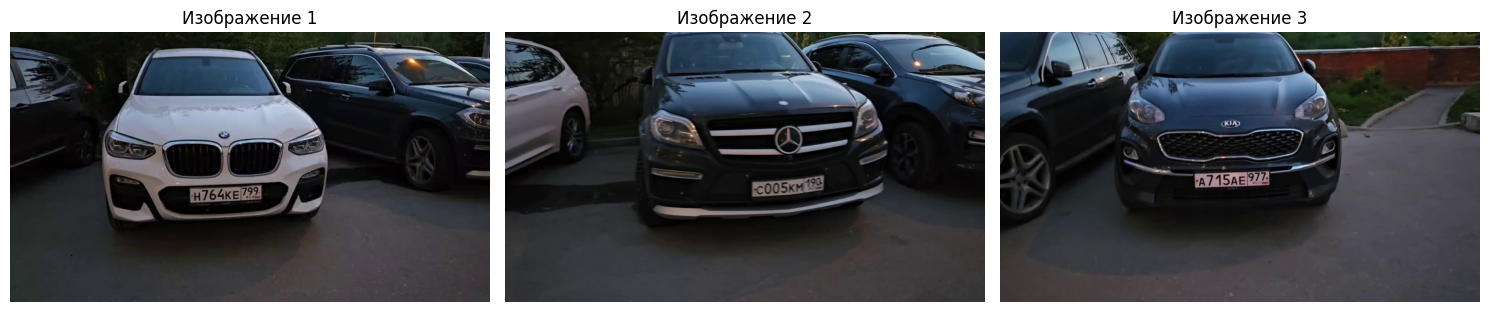

In [3]:
def load_images(folder_name):

    script_dir = os.path.dirname(os.path.abspath('__file__'))
    folder_path = os.path.join(script_dir, folder_name)
    
    images = []
    valid_extensions = ('.jpg', '.jpeg')
    
    if not os.path.exists(folder_path):
        print(f"Папка не найдена: {folder_path}")
        return images
    
    for filename in sorted(os.listdir(folder_path)):
        if filename.lower().endswith(valid_extensions):
            filepath = os.path.join(folder_path, filename)
            img = cv2.imread(filepath)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img)
                print(f"Загружено: {filename}")
            else:
                print(f"Не удалось прочитать: {filename}")
    
    return images

def display_images(images, titles, figsize=(15, 10)):
    n = len(images)
    if n == 0:
        print("Нет изображений для отображения")
        return
    
    cols = min(3, n)
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if rows == 1 and cols == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes
    else:
        axes = axes.flatten()
    
    for i in range(n):
        if len(images[i].shape) == 3:
            axes[i].imshow(images[i])
        else:
            axes[i].imshow(images[i], cmap='gray')
        axes[i].axis('off')
        if titles and i < len(titles):
            axes[i].set_title(titles[i])

    for i in range(n, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
print("="*45)
print("1. ЗАГРУЗКА ВСЕХ ИЗОБРАЖЕНИЙ ИЗ ПАПКИ DATASET")
print("="*45)

input_images = load_images("dataset")

display_images(input_images, [f"Изображение {i+1}" for i in range(len(input_images))])

## Аугментация изображений

Этот код применяет **случайные искажения** к изображениям.

Применяемые преобразования:
- `apply_rotation` — случайное вращение на угол от -5° до +5°.
- `add_noise` — добавление случайного шума.
- `adjust_brightness` — изменение яркости.
- `apply_perspective_transform` — перспективное искажение.

Функция `augment_image` выбирает **2 случайных преобразования** и применяет их к каждому изображению.

Затем отображаются:
- **Исходные изображения**
- **Аугментированные версии**



2. АУГМЕНТАЦИЯ ДЛЯ СОЗДАНИЯ РЕАЛИСТИЧНЫХ ИСКАЖЕНИЙ
✓ Аугментировано изображение 1
✓ Аугментировано изображение 2
✓ Аугментировано изображение 3

Исходные изображения:


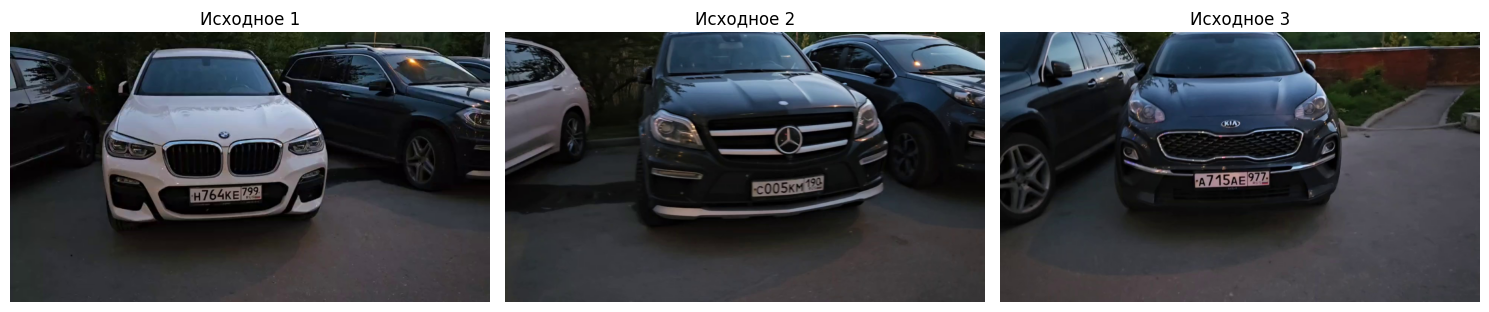

Аугментированные изображения:


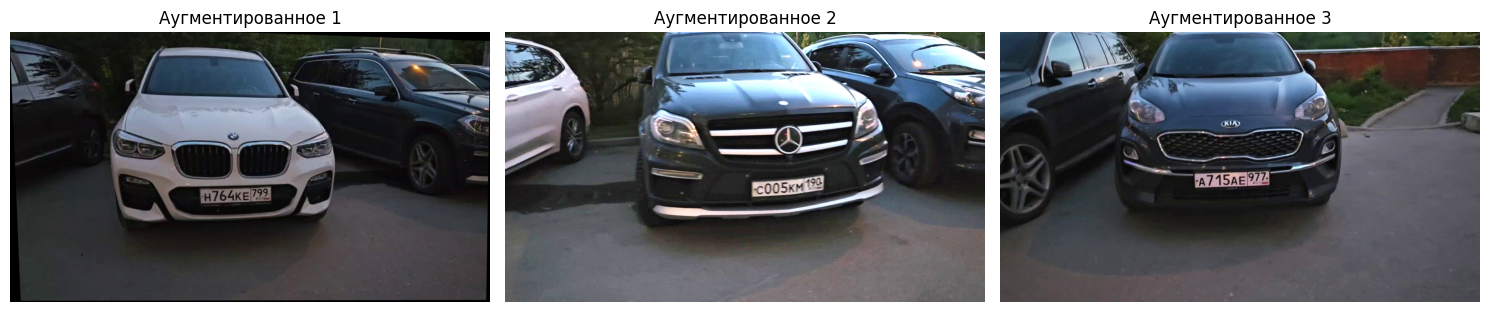

In [4]:
def apply_rotation(img):
    angle = random.uniform(-5, 5) 
    center = (img.shape[1] // 2, img.shape[0] // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(img, rotation_matrix, (img.shape[1], img.shape[0]))
    return rotated

def add_noise(img):
    noise_level = random.uniform(0.5, 1.5)
    noise = np.random.normal(0, noise_level * 255, img.shape).astype(np.int16)
    noisy_img = cv2.addWeighted(img, 0.95, noise.astype(np.uint8), 0.05, 0)
    return np.clip(noisy_img, 0, 255).astype(np.uint8)

def adjust_brightness(img):
    brightness_factor = random.uniform(0.8, 2)
    bright_img = cv2.convertScaleAbs(img, alpha=brightness_factor, beta=0)
    return bright_img

def apply_gaussian_blur(img):
    kernel_size = random.choice([3, 5])
    blurred = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    return blurred

def apply_perspective_transform(img):
    h, w = img.shape[:2]
    offset = min(w, h) * 0.05
    src_points = np.float32([[0, 0], [w, 0], [w, h], [0, h]])
    dst_points = np.float32([
        [random.uniform(-offset, offset), random.uniform(-offset, offset)],
        [w + random.uniform(-offset, offset), random.uniform(-offset, offset)],
        [w + random.uniform(-offset, offset), h + random.uniform(-offset, offset)],
        [random.uniform(-offset, offset), h + random.uniform(-offset, offset)]
    ])
    
    perspective_matrix = cv2.getPerspectiveTransform(src_points, dst_points)
    transformed = cv2.warpPerspective(img, perspective_matrix, (w, h))
    return transformed

def augment_image(img):
    transformations = [
        apply_rotation,
        add_noise,
        adjust_brightness,
        apply_gaussian_blur,
        apply_perspective_transform
    ]
    
    selected_transforms = random.sample(transformations, 2)
    
    augmented_img = img.copy()
    for transform in selected_transforms:
        augmented_img = transform(augmented_img)
    
    return augmented_img

print("\n" + "="*60) 
print("2. АУГМЕНТАЦИЯ ДЛЯ СОЗДАНИЯ РЕАЛИСТИЧНЫХ ИСКАЖЕНИЙ")
print("="*60)

augmented_images = []
for i, img in enumerate(input_images):
    augmented = augment_image(img)
    augmented_images.append(augmented)
    print(f"✓ Аугментировано изображение {i+1}")

print("\nИсходные изображения:")
display_images(input_images, [f"Исходное {i+1}" for i in range(len(input_images))])

print("Аугментированные изображения:")
display_images(augmented_images, [f"Аугментированное {i+1}" for i in range(len(augmented_images))])

## Предобработка изображений

Код ниже подготавливает изображения к распознаванию.

Этапы предобработки:
1. **Преобразование в LAB** и выделение канала яркости (L).
2. **Шумоподавление** с помощью `fastNlMeansDenoising`.
3. **Усиление контраста** через `CLAHE` (адаптивное гистограммное выравнивание).
4. **Бинаризация** изображения с помощью `adaptiveThreshold`.
5. **Морфологическая операция** замыкания (`MORPH_CLOSE`) для устранения пробелов.

Визуализация:
- Сравнение изображений **до** и **после** предобработки.



ПРЕДОБРАБОТКА ИЗОБРАЖЕНИЙ

До обработки:


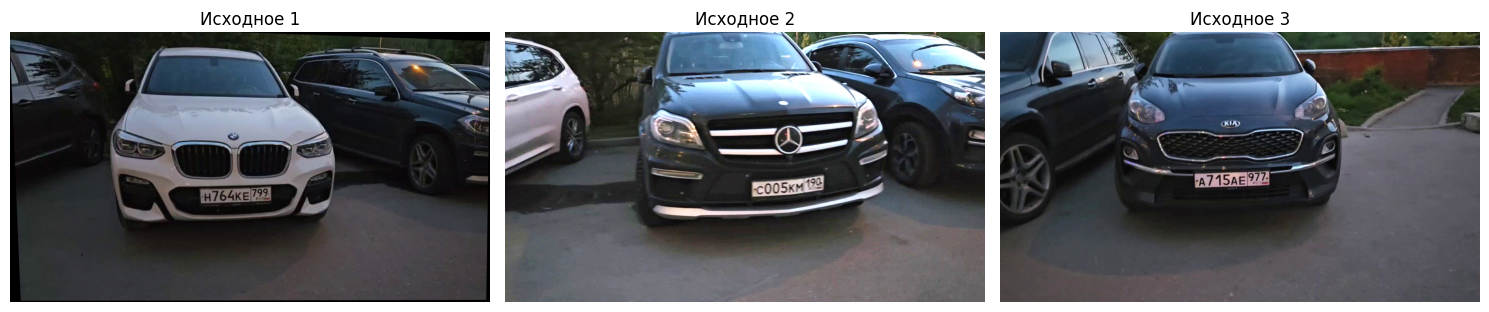

После обработки:


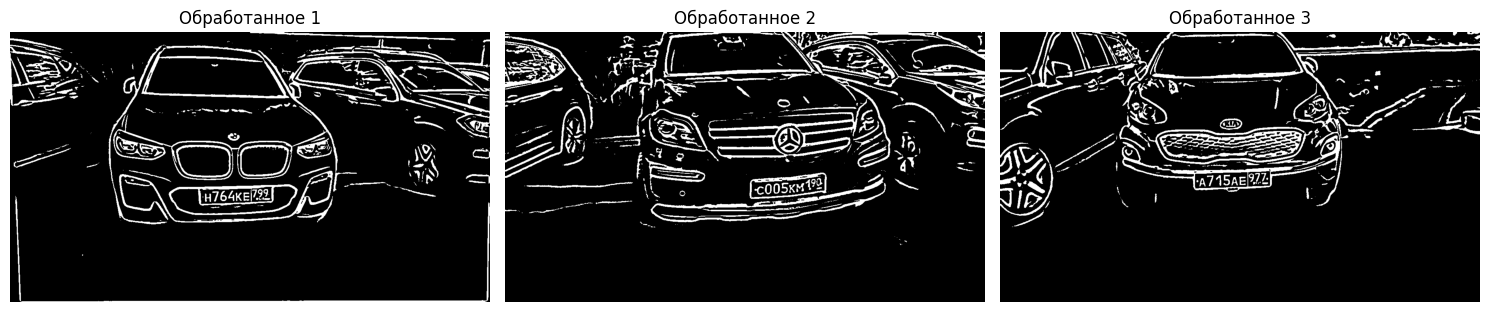

In [10]:
def preprocess_image(img):

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)[:,:,0]

    denoised = cv2.fastNlMeansDenoising(
        gray, 
        h=15,
        templateWindowSize=7,
        searchWindowSize=21
    )
    
    clahe = cv2.createCLAHE(
        clipLimit=3.0,
        tileGridSize=(12, 12)
    )
    enhanced = clahe.apply(denoised)
    
    binary = cv2.adaptiveThreshold(
        enhanced,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        21,
        9
    )
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    processed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    
    return processed

print("\n" + "="*25)
print("ПРЕДОБРАБОТКА ИЗОБРАЖЕНИЙ")
print("="*25)

preprocessed_images = []

for i, img in enumerate(augmented_images):
    
    processed = preprocess_image(img)
    inv = 255 - processed
    preprocessed_images.append(processed)

print("\nДо обработки:")
display_images(augmented_images, [f"Исходное {i+1}" for i in range(len(augmented_images))])

print("После обработки:")
display_images(preprocessed_images, [f"Обработанное {i+1}" for i in range(len(preprocessed_images))])



=== Обработка изображения 1 ===


Площадь: 3599.5
Начальная точка: 29, 454 -> Ширина не подходит: 1251 (70, 300)



Площадь: 22834.5
Начальная точка: 423, 406 -> Ширина не подходит: 344 (70, 300)



Площадь: 5131.0
Начальная точка: 505, 417 
 Ширина: 139 
 Высота: 43
Плотность: 0.05 < 0.3603814622720428 < 0.8)
Кандидат: 505, 417, 139, 43, Площадь: 5131.0, Соотношение: 3.2325581395348837, Плотность: 0.3603814622720428, Балл: 3605.707785642063



Площадь: 11049.5
Начальная точка: 429, 411 -> Ширина не подходит: 332 (70, 300)



Площадь: 8899.5
Начальная точка: 291, 370 -> Ширина не подходит: 570 (70, 300)



Площадь: 3583.5
Соотношение сторон не подходит: 0.9493670886075949 (2.0, 5.0)



Площадь: 3258.0
Начальная точка: 760, 75 -> Высота не подходит: 113 (20, 100)



Площадь: 36395.5
Начальная точка: 275, 49 -> Ширина не подходит: 861 (70, 300)



Площадь: 13830.5
Соотношение сторон не подходит: 1.62 (2.0, 5.0)



Площадь: 10930.5
Соотношение сторон не подходит: 1.6781609195402298 (2.0,

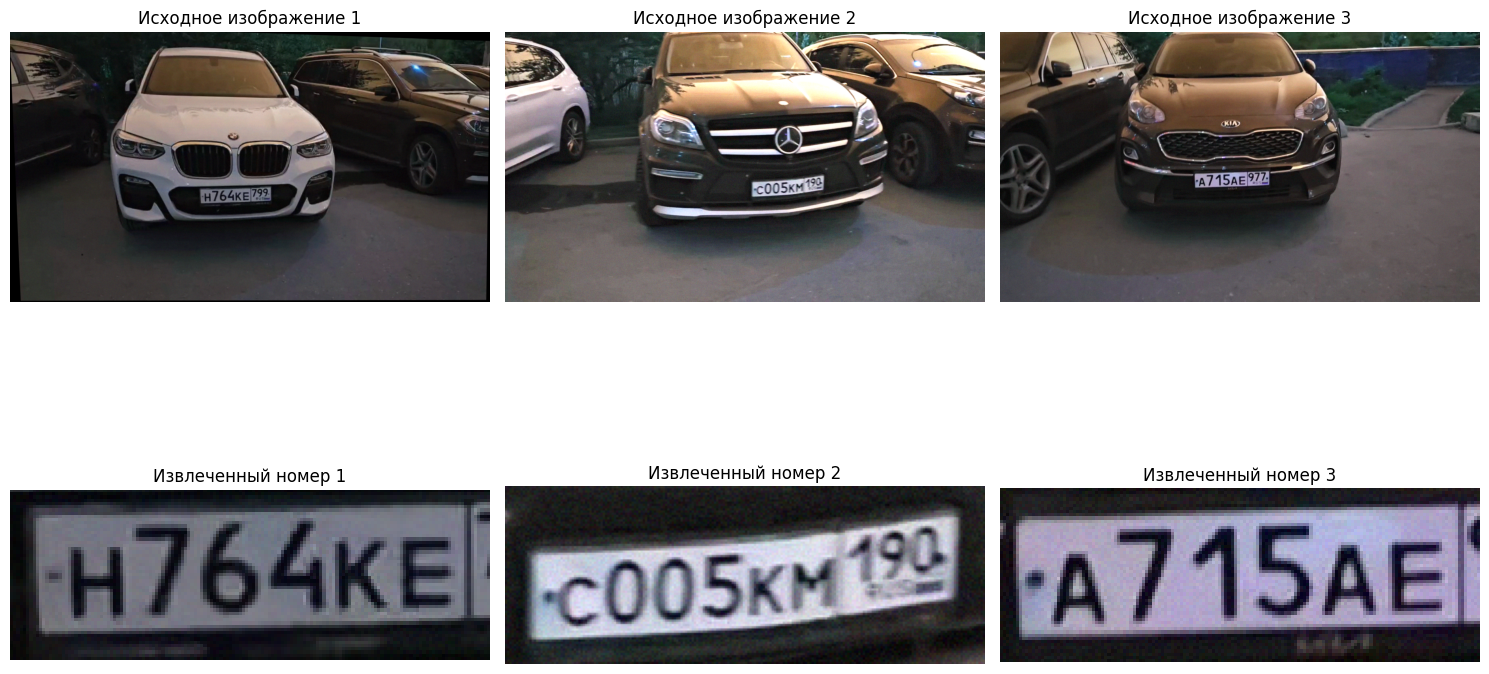

In [11]:
def get_plate(augmented_images, preprocessed_images):

    def filter_by_area(contour, min_area=3000):
        area = cv2.contourArea(contour)
        if area > min_area:
            print("\n" + "="*60 + "\n")
            print(f'Площадь: {area}')
            return area 
        else: 
            return None
    
    def filter_by_aspect_ratio(x, y, w, h, min_ratio=2.0, max_ratio=5.0, min_w=70, max_w=300, min_h=20, max_h=100):
        aspect_ratio = w / h
        if (min_ratio < aspect_ratio < max_ratio):
            if (min_w < w < max_w):
                if(min_h < h < max_h):
                    print(f'Начальная точка: {x}, {y} \n Ширина: {w} \n Высота: {h}')
                    return aspect_ratio
                else:
                    print(f'Начальная точка: {x}, {y} -> Высота не подходит: {h} ({min_h}, {max_h})')
                    print("\n" + "="*60)
                    return None
            print(f'Начальная точка: {x}, {y} -> Ширина не подходит: {w} ({min_w}, {max_w})')
            print("\n" + "="*60)
            return None
        else:
            print(f'Соотношение сторон не подходит: {aspect_ratio} ({min_ratio}, {max_ratio})')
            print("\n" + "="*60)
            return None

    def filter_by_density(roi, min_density=0.05, max_density=0.8):
        white_pixels = np.sum(roi == 255)
        total_pixels = roi.shape[0] * roi.shape[1]
        density = white_pixels / total_pixels
        if min_density < density < max_density:
            print(f'Плотность: {min_density} < {density} < {max_density})')
            return density
        else:
            print(f'Плотность не подходит: {density} (Min: {min_density}, Max: {max_density})')
            print("\n" + "="*60)
            return None

    def calculate_score(area, aspect_ratio, ideal_ratio=4.6):
        ratio_diff = abs(aspect_ratio - ideal_ratio)
        score = area * max(0, (1 - ratio_diff / ideal_ratio))
        return score

    def distance_from_center(candidate, image_center_x):
        x, y, w, h, score = candidate
        center_x = x + w / 2
        return abs(center_x - image_center_x)
    
    def find_plate_contour_precise(preprocessed_img, top_n=3):

        plate_candidates = []
        gray = preprocessed_img.copy()
        contours, _ = cv2.findContours(gray, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        for contour in contours:

            area = filter_by_area(contour)
            if not area:
                continue
                
            x, y, w, h = cv2.boundingRect(contour)
            aspect_ratio = filter_by_aspect_ratio(x, y, w, h)
            if not aspect_ratio:
                continue

            roi = gray[y:y+h, x:x+w]
            density = filter_by_density(roi)
            if not density:
                continue

            score = calculate_score(area, aspect_ratio)
            if score > 0:
                print(f'Кандидат: {x}, {y}, {w}, {h}, Площадь: {area}, Соотношение: {aspect_ratio}, Плотность: {density}, Балл: {score}')
                print("\n" + "="*60)
                plate_candidates.append((x, y, w, h, score))
        
        if not plate_candidates:
            return None
        
        plate_candidates = sorted(plate_candidates, key=lambda x: x[4], reverse=True)
        top_candidates = plate_candidates[:top_n]

        image_center_x = gray.shape[1] / 2
        best_candidate = min(top_candidates, key=lambda c: distance_from_center(c, image_center_x))
        return best_candidate[:4]
    
    def extract_plate_region(original_img, preprocessed_img):
        plate_coords = None
        plate_coords = find_plate_contour_precise(preprocessed_img)
        if plate_coords is not None:
            x, y, w, h = plate_coords
            if not (w > 30 and h > 10 and w < original_img.shape[1] * 0.8 and h < original_img.shape[0] * 0.3):
                plate_coords = None
        
        if plate_coords is not None:
            x, y, w, h = plate_coords
            padding = 5
            x = max(0, x - padding)
            y = max(0, y - padding)
            w = min(original_img.shape[1] - x, w + 2*padding)

            h = min(original_img.shape[0] - y, h + 2*padding)
            
            # Извлекаем область из оригинального изображения
            if w > 0 and h > 0:
                plate_region = original_img[y:y+h, x:x+w]
                return plate_region
        
        return None
    
    extracted_plates = []
    
    for i in range(len(augmented_images)):
        print(f"\n=== Обработка изображения {i+1} ===")
        
        original = augmented_images[i]
        preprocessed = preprocessed_images[i]
        
        # Отладочная информация
        #debug_preprocessing(preprocessed, i+1)
        
        # Извлекаем область номера
        plate = extract_plate_region(original, preprocessed)
        
        if plate is not None and plate.size > 0:
            extracted_plates.append(plate)
            print(f"✓ Номер найден! Размер: {plate.shape[1]}x{plate.shape[0]}")
        else:
            print("✗ Номер не найден")
            extracted_plates.append(None)
    
    return extracted_plates

def display_results(original_images, extracted_plates):
    """Функция для отображения результатов"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    for i in range(3):
        # Исходные изображения
        if len(original_images[i].shape) == 3:
            axes[0, i].imshow(cv2.cvtColor(original_images[i], cv2.COLOR_BGR2RGB))
        else:
            axes[0, i].imshow(original_images[i], cmap='gray')
        axes[0, i].set_title(f'Исходное изображение {i+1}')
        axes[0, i].axis('off')
        
        # Извлеченные номера
        if extracted_plates[i] is not None:
            if len(extracted_plates[i].shape) == 3:
                axes[1, i].imshow(cv2.cvtColor(extracted_plates[i], cv2.COLOR_BGR2RGB))
            else:
                axes[1, i].imshow(extracted_plates[i], cmap='gray')
            axes[1, i].set_title(f'Извлеченный номер {i+1}')
        else:
            axes[1, i].text(0.5, 0.5, 'Номер не найден', ha='center', va='center', transform=axes[1, i].transAxes)
            axes[1, i].set_title(f'Номер {i+1} не найден')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()
# Извлечение номеров
found_plates = get_plate(augmented_images, preprocessed_images)

display_results(augmented_images, found_plates)


ПОИСК ОБЛАСТИ С ТЕКСТОМ С ПОМОЩЬЮ PPOCR
✓ Найдена область номера на изображении 1
✓ Найдена область номера на изображении 2
✓ Найдена область номера на изображении 3

Найдено областей с номерами: 3


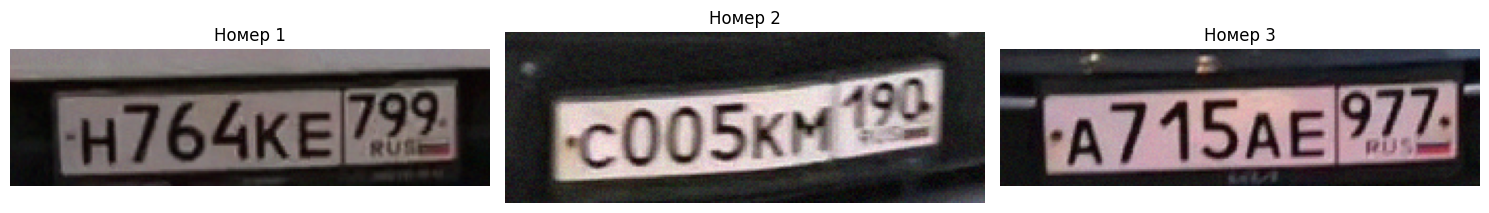

In [36]:
def get_plate_ppocr(
    detector,                     
    original_img: np.ndarray,     
    binary_img: Optional[np.ndarray] = None  # предобработанное изображение (опционально)
) -> Optional[np.ndarray]:
    
    height, width = 736, 736
    input_img = cv2.resize(original_img, (width, height))
    scale_h = original_img.shape[0] / height
    scale_w = original_img.shape[1] / width

    # Предсказание
    results = detector.infer(input_img)

    # Масштабируем обратно координаты
    scaled_boxes = []
    for box in results[0]:
        scaled_box = np.array([[int(pt[0] * scale_w), int(pt[1] * scale_h)] for pt in box])
        scaled_boxes.append(scaled_box)

    # Фильтрация по размеру и соотношению сторон
    plate_candidates = []
    for box in scaled_boxes:
        x, y, w, h = cv2.boundingRect(box)
        aspect_ratio = w / h
        area = w * h
        img_area = original_img.shape[0] * original_img.shape[1]

        if (1.5 <= aspect_ratio <= 7.5 and
            area > img_area * 0.003 and
            w > 50 and h > 15):
            plate_candidates.append((x, y, w, h))

    if not plate_candidates:
        return None

    # Выбираем крупнейший кандидат
    x, y, w, h = max(plate_candidates, key=lambda item: item[2] * item[3])
    margin_x = max(10, int(w * 0.05))
    margin_y = max(10, int(h * 0.1))

    x = max(0, x - margin_x)
    y = max(0, y - margin_y)
    w = min(original_img.shape[1] - x, w + margin_x)
    h = min(original_img.shape[0] - y, h + margin_y)

    plate = original_img[y:y + h, x:x + w]
    return plate

print("\n" + "="*60)
print("ПОИСК ОБЛАСТИ С ТЕКСТОМ С ПОМОЩЬЮ PPOCR")
print("="*60)

found_plates = []
for i, (orig_img, preproc_img) in enumerate(zip(augmented_images, preprocessed_images)):
    plate = get_plate_ppocr(ppocr_model, orig_img, preproc_img)
    if plate is not None:
        found_plates.append(plate)
        print(f"✓ Найдена область номера на изображении {i+1}")
    else:
        print(f"✗ Область номера не найдена на изображении {i+1}")
        found_plates.append(np.ones((50, 100, 3), dtype=np.uint8) * 128)

print(f"\nНайдено областей с номерами: {len([p for p in found_plates if p.shape[0] > 50])}")
display_images(found_plates, [f"Номер {i+1}" for i in range(len(found_plates))])

In [112]:
def rotate_image(image: np.ndarray, angle: float) -> np.ndarray:
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)
    cos, sin = abs(rot_mat[0, 0]), abs(rot_mat[0, 1])
    new_w = int(h * sin + w * cos)
    new_h = int(h * cos + w * sin)
    rot_mat[0, 2] += (new_w / 2) - center[0]
    rot_mat[1, 2] += (new_h / 2) - center[1]
    return cv2.warpAffine(image, rot_mat, (new_w, new_h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

def rotate_by_contours(image: np.ndarray, gray: np.ndarray) -> np.ndarray:
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return image
    rect = cv2.minAreaRect(max(contours, key=cv2.contourArea))
    angle = rect[2]
    angle = 90 + angle if angle < -45 else angle
    return rotate_image(image, -angle)

def rotate_license_plate(image: np.ndarray, force_check: bool = True) -> np.ndarray:
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image.copy()
    h, w = image.shape[:2]
    if (w / h) < 1.5 and force_check:
        image = rotate_image(image, 90)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
    edges = cv2.Canny(cv2.GaussianBlur(gray, (5, 5), 0), 50, 150)
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 50)
    if lines is None:
        return rotate_by_contours(image, gray)
    h_angles, v_angles = [], []
    for rho, theta in lines[:, 0]:
        angle = np.rad2deg(theta)
        if angle >= 180:
            angle -= 180
        if angle < 45 or angle > 135:
            h_angles.append(angle - 180 if angle > 135 else angle)
        else:
            v_angles.append(angle - 90)
    angles = h_angles if len(h_angles) >= len(v_angles) else v_angles
    if not angles:
        return image
    rot_angle = np.median(angles)
    return rotate_image(image, rot_angle) if abs(rot_angle) > 2 else image

def process_multiple_images(image_arrays: list) -> list:
    results = []
    for img in image_arrays:
        if isinstance(img, np.ndarray):
            try:
                results.append(rotate_license_plate(img))
            except:
                results.append(None)
        else:
            results.append(None)
    return results

def check_orientation_and_rotate(image: np.ndarray) -> np.ndarray:
    h, w = image.shape[:2]
    return rotate_image(image, 90) if (w / h) < 1.5 else image

def smart_rotate_license_plate(image: np.ndarray) -> np.ndarray:
    if not isinstance(image, np.ndarray):
        raise ValueError("Неверный формат изображения")
    corrected = check_orientation_and_rotate(image)
    return rotate_license_plate(corrected, force_check=False)

# Пример обработки и сохранения
rotated_images = process_multiple_images(found_plates)
for i, img in enumerate(rotated_images):
    if img is not None:
        cv2.imwrite(f'номер_{i+1}_повернутый.jpg', img)



5. ПРЕДОБРАБОТКА ОБЛАСТИ С ТЕКСТОМ
✓ Обработана область номера 1
✓ Обработана область номера 2
✓ Обработана область номера 3

Области номеров после обработки:


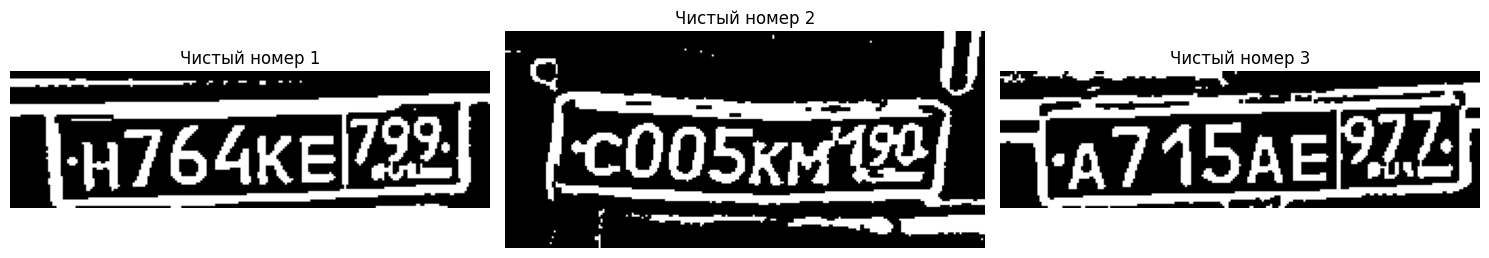

In [113]:
def get_clean_plate(plate):
    if plate.shape[0] <= 50:
        return plate
    
    gray = cv2.cvtColor(plate, cv2.COLOR_RGB2GRAY) if len(plate.shape) == 3 else plate.copy()
    
    denoised = cv2.fastNlMeansDenoising(gray, h=10, templateWindowSize=7, searchWindowSize=21)
    # Улучшение контраста
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(denoised)
    
    binary = cv2.adaptiveThreshold(
        enhanced,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        blockSize=15,
        C=6 
        )

    kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel_close)

    kernel_open = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
    processed = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel_open)

    kernel_dilate = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
    bold = cv2.dilate(processed, kernel_dilate, iterations=1)

    return bold


print("\n" + "="*60)
print("5. ПРЕДОБРАБОТКА ОБЛАСТИ С ТЕКСТОМ")
print("="*60)

# Обрабатываем найденные области номеров
clean_plates = []
for i, plate in enumerate(rotated_images):
    clean_plate = get_clean_plate(plate)
    clean_plates.append(clean_plate)
    if plate.shape[0] > 50:
        print(f"✓ Обработана область номера {i+1}")

print("\nОбласти номеров после обработки:")
display_images(clean_plates, [f"Чистый номер {i+1}" for i in range(len(clean_plates))])

In [108]:
def get_raw_text(clean_plate):
    if clean_plate.shape[0] <= 50:  # Пустое изображение
        return ""
    
    try:
        # Используем EasyOCR для распознавания
        results = reader.readtext(
            clean_plate,
            allowlist='ABCDEFGHIJKLMNOPQRSTUVWXYZАВЕКМНОРСТУХ0123456789',
            paragraph=False,
            width_ths=0.7,
            height_ths=0.7
        )
        
        if results:
            # Берем результат с наивысшей уверенностью
            best_result = max(results, key=lambda x: x[2])
            text = best_result[1]
            confidence = best_result[2]
            
            
            if confidence > 0.3:
                return text.upper().replace(' ', '')
        
        # Альтернативный метод с другими настройками
        results_alt = reader.readtext(
            clean_plate,
            paragraph=False,
            width_ths=0.5,
            height_ths=0.5
        )
        
        if results_alt:
            best_alt = max(results_alt, key=lambda x: len(x[1]) * x[2])
            return best_alt[1].upper().replace(' ', '')
        
    except Exception as e:
        print(f"Ошибка при распознавании: {e}")
    
    return ""

print("\n" + "="*60)
print("6. РАСПОЗНАВАНИЕ ТЕКСТА")
print("="*60)

# Распознаем текст на обработанных номерах
raw_texts = []
for i, clean_plate in enumerate(clean_plates):
    raw_text = get_raw_text(clean_plate)
    raw_texts.append(raw_text)
    if raw_text:
        print(f"✓ Распознан текст на номере {i+1}: '{raw_text}'")
    else:
        print(f"✗ Текст не распознан на номере {i+1}")

print(f"\nРаспознанные тексты: {raw_texts}")


6. РАСПОЗНАВАНИЕ ТЕКСТА
✓ Распознан текст на номере 1: 'Н754KE799'
✓ Распознан текст на номере 2: 'СОО5KM199'
✓ Распознан текст на номере 3: 'А7154EР7Z'

Распознанные тексты: ['Н754KE799', 'СОО5KM199', 'А7154EР7Z']


In [109]:
def get_number(raw_text: str) -> str:
    if not raw_text:
        return ""

    raw_text = raw_text.upper()

    valid_letters = "АВЕКМНОРСТУХ"

    latin_to_cyrillic = {
        'A': 'А', 'B': 'В', 'C': 'С', 'E': 'Е', 'H': 'Н',
        'K': 'К', 'M': 'М', 'O': 'О', 'P': 'Р', 'T': 'Т',
        'X': 'Х', 'Y': 'У', 'S': 'С', 'Z': '7', 'V': 'В', 'L': 'Л'
    }

    letter_to_digit = {
        'О': '0', 'З': '3', 'В': '8', 'Б': '6', 'Г': '9', 'Т': '7',
        'С': '5', 'Л': '1', 'Е': '3', 'Н': '4', 'А': '4', 'Р': '9'
    }

    digit_to_letter = {v: k for k, v in letter_to_digit.items()}

    fixed_text = "".join(latin_to_cyrillic.get(ch, ch) for ch in raw_text)

    fixed_text = re.sub(f"[^\d{valid_letters}]", "", fixed_text)

    if not (8 <= len(fixed_text) <= 10):
        return ""

    def fix_letter(ch):
        if ch in valid_letters:
            return ch
        return digit_to_letter.get(ch)

    def fix_digit(ch):
        if ch.isdigit():
            return ch
        return letter_to_digit.get(ch)

    if len(fixed_text) < 8:
        return ""

    letter1 = fix_letter(fixed_text[0])
    if not letter1:
        return ""

    digits_part = []
    for i in range(1, 4):
        if i >= len(fixed_text):
            return ""
        d = fix_digit(fixed_text[i])
        if not d:
            return ""
        digits_part.append(d)

    letters2 = []
    for i in range(4, 6):
        if i >= len(fixed_text):
            return ""
        l = fix_letter(fixed_text[i])
        if not l:
            return ""
        letters2.append(l)

    region_raw = fixed_text[6:]
    region_digits = ""
    for ch in region_raw:
        d = fix_digit(ch)
        if not d:
            return ""
        region_digits += d

    if len(region_digits) not in (2, 3):
        return ""

    try:
        reg_num = int(region_digits)
        if not (1 <= reg_num <= 1999):
            allowed_special = {777, 999, 197, 178, 716}
            if reg_num not in allowed_special:
                return ""
    except ValueError:
        return ""

    return f"{letter1}{''.join(digits_part)}{''.join(letters2)} {region_digits}"

for raw in raw_texts:
    corrected = get_number(raw)
    print(f"Исходный: {raw} -> Скорректированный: {corrected if corrected else 'НЕ ВАЛИДНЫЙ'}")


Исходный: Н754KE799 -> Скорректированный: Н754КЕ 799
Исходный: СОО5KM199 -> Скорректированный: С005КМ 199
Исходный: А7154EР7Z -> Скорректированный: А715АЕ 977


In [110]:
reference_texts = ['Н764КЕ 799', 'С005КМ 190', 'А715АЕ 977']

def cer(predicted, reference):
    m, n = len(predicted), len(reference)
    dp = [[0] * (n + 1) for _ in range(m + 1)]

    for i in range(m + 1):
        dp[i][0] = i
    for j in range(n + 1):
        dp[0][j] = j

    for i in range(1, m + 1):
        for j in range(1, n + 1):
            cost = 0 if predicted[i - 1] == reference[j - 1] else 1
            dp[i][j] = min(
                dp[i - 1][j] + 1,
                dp[i][j - 1] + 1,
                dp[i - 1][j - 1] + cost
            )
    distance = dp[m][n]
    return distance / max(len(reference), 1)

for raw, ref in zip(raw_texts, reference_texts):
    error = cer(raw, ref)
    print(f"Распознан: {raw}, Эталон: {ref}, CER: {error:.3f}")

Распознан: Н754KE799, Эталон: Н764КЕ 799, CER: 0.400
Распознан: СОО5KM199, Эталон: С005КМ 190, CER: 0.600
Распознан: А7154EР7Z, Эталон: А715АЕ 977, CER: 0.500
